In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, explained_variance_score, mean_absolute_error, mean_squared_error
%matplotlib inline 

### MLL Results

In [4]:
path = '/mnt/researchdrive/BOX_INTERNAL/opotowsky/'
uncs = [0.05, 0.1, 0.15, 0.2]
job_dirs = ['Job' + str(i) + '_unc' + str(unc) for i, unc in enumerate(uncs)]
mll = {}
for i, unc_job in enumerate(job_dirs):
    mll['unc' + str(i)] = pd.read_csv(path + 'mll/nuc_conc/train/' + unc_job + '/' + unc_job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

In [36]:
rxtr_mll = []
burn_mll = []
enri_mll = []
cool_mll = []
rxtr_mll_std = []
for i, unc_job in enumerate(uncs):
    key = 'unc' + str(i)
    rxtr_mll.append(accuracy_score(mll[key]['ReactorType'], mll[key]['pred_ReactorType']))
    rxtr_mll_std.append(np.std(mll[key]['ReactorType_Score']))
    burn_mll.append(explained_variance_score(mll[key]['Burnup'], mll[key]['pred_Burnup']))
    enri_mll.append(explained_variance_score(mll[key]['Enrichment'], mll[key]['pred_Enrichment']))
    cool_mll.append(explained_variance_score(mll[key]['CoolingTime'], mll[key]['pred_CoolingTime']))

In [35]:
burn_mll_mae = []
enri_mll_mae = []
cool_mll_mae = []
burn_mll_std = []
enri_mll_std = []
cool_mll_std = []
for i, unc_job in enumerate(uncs):
    burn_mll_mae.append(-mean_absolute_error(mll['unc'+str(i)]['Burnup'], mll['unc'+str(i)]['pred_Burnup']))
    enri_mll_mae.append(-mean_absolute_error(mll['unc'+str(i)]['Enrichment'], mll['unc'+str(i)]['pred_Enrichment']))
    cool_mll_mae.append(-mean_absolute_error(mll['unc'+str(i)]['CoolingTime'], mll['unc'+str(i)]['pred_CoolingTime']))
    burn_mll_std.append(np.std(mll['unc'+str(i)]['Burnup_Error']))
    enri_mll_std.append(np.std(mll['unc'+str(i)]['Enrichment_Error']))
    cool_mll_std.append(np.std(mll['unc'+str(i)]['CoolingTime_Error']))

### Scikit Results

In [8]:
learn_path = 'scikit/conc_rand_err/'
csv_end = '_nuc29_random_error.csv'
fracs = ['1.0']#['0.1', '0.3', '1.0']
burn_knn = {}
burn_dtr = {}
rxtr_knn = {}
rxtr_dtr = {}
enri_knn = {}
enri_dtr = {}
cool_knn = {}
cool_dtr = {}
for frac in fracs:
    burn_knn['tset'+frac] = pd.read_csv(path + learn_path + 'burnup_knn_tset' + frac + csv_end).drop(columns='Unnamed: 0')
    burn_dtr['tset'+frac] = pd.read_csv(path + learn_path + 'burnup_dtree_tset' + frac + csv_end).drop(columns='Unnamed: 0')
    rxtr_knn['tset'+frac] = pd.read_csv(path + learn_path + 'reactor_knn_tset' + frac + csv_end).drop(columns='Unnamed: 0')
    rxtr_dtr['tset'+frac] = pd.read_csv(path + learn_path + 'reactor_dtree_tset' + frac + csv_end).drop(columns='Unnamed: 0')
    enri_knn['tset'+frac] = pd.read_csv(path + learn_path + 'enrichment_knn_tset' + frac + csv_end).drop(columns='Unnamed: 0')
    enri_dtr['tset'+frac] = pd.read_csv(path + learn_path + 'enrichment_dtree_tset' + frac + csv_end).drop(columns='Unnamed: 0')
    cool_knn['tset'+frac] = pd.read_csv(path + learn_path + 'cooling_knn_tset' + frac + csv_end).drop(columns='Unnamed: 0')
    cool_dtr['tset'+frac] = pd.read_csv(path + learn_path + 'cooling_dtree_tset' + frac + csv_end).drop(columns='Unnamed: 0')

# Plotting

In [13]:
# color dict (use: colors['XColor'])
colors = {'DBrwn' : '#8c510a', 'MBrwn' : '#d8b365', 'LBrwn' : '#f6e8c3',
          'DTeal' : '#01665e', 'MTeal' : '#5ab4ac', 'LTeal' : '#c7eae5',
          'DPurp' : '#762a83', 'MPurp' : '#af8dc3', 'LPurp' : '#e7d4e8'
         }

In [81]:
def plot_curves(title, err_type): 
    plt.clf()    
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111)   
    ax.set_title(title, fontsize=20, pad=15)
    
    sv_base = '../plots/final2021/randerr_compare_nuc29_' + err_type
    knn_err = 'kNN ' + err_type
    dtr_err = 'DTree ' + err_type
    knn_std = 'kNN ' + err_type + ' Std'
    dtr_std = 'DTree ' + err_type + ' Std'
    mae_axlbl = 'Negative ' + err_type
    if 'Burnup' in title:
        if err_type == 'MAE':
            mll = burn_mll_mae
            mae_axlbl = mae_axlbl + ' [MWd/MTU]'
        elif err_type == 'RMSE':
            mll = burn_mll_rms
        else:
            mll = burn_mll
        knn = burn_knn
        dtr = burn_dtr
        std = burn_mll_std
        sv_fig = sv_base + '_burn.png'
    elif 'Reactor' in title:
        knn = rxtr_knn
        dtr = rxtr_dtr
        mll = rxtr_mll
        std = rxtr_mll_std
        sv_fig = sv_base + '_rxtr.png'
    elif 'Enrichment' in title:
        if err_type == 'MAE':
            mll = enri_mll_mae
            mae_axlbl = mae_axlbl + ' [% U235]'
        elif err_type == 'RMSE':
            mll = enri_mll_rms
        else:
            mll = burn_mll
        knn = enri_knn
        dtr = enri_dtr
        std = rxtr_mll_std
        sv_fig = sv_base + '_enri.png'
    else:
        if err_type == 'MAE':
            mll = cool_mll_mae
            mae_axlbl = mae_axlbl + ' [days]'
        elif err_type == 'RMSE':
            mll = cool_mll_rms
        else:
            mll = burn_mll
        knn = cool_knn
        dtr = cool_dtr
        std = cool_mll_std
        sv_fig = sv_base + '_cool.png'
    ax.set_xlabel('Percent Error', fontsize=20, labelpad=15)
    if err_type == 'Acc':
        ax.set_ylabel('Accuracy Score', fontsize=20, labelpad=15)
    elif err_type == 'ExpVar':
        ax.set_ylabel('Explained Variance', fontsize=20, labelpad=15)
    else:
        ax.set_ylabel(mae_axlbl, fontsize=20, labelpad=15)
    
    ## Scikit Results
    err = burn_knn['tset1.0']['Percent Error']
    tset = ['tset1.0']#['tset0.1', 'tset0.3', 'tset1.0']
    hue = {'tset0.1' : 'L', 'tset0.3' : 'M', 'tset1.0' : 'D'}
    for t in tset:
        ax.fill_between(err, knn[t][knn_err] - knn[t][knn_std], knn[t][knn_err] + knn[t][knn_std], color=colors[hue[t]+'Brwn'], alpha=0.2)
        ax.fill_between(err, dtr[t][dtr_err] - dtr[t][dtr_std], dtr[t][dtr_err] + dtr[t][dtr_std], color=colors[hue[t]+'Teal'], alpha=0.2)
        ax.plot(err, knn[t][knn_err], 'o-', color=colors[hue[t]+'Brwn'], mew=0, ms=5, label='kNN')#, Set Frac: ' + t[4:])
        ax.plot(err, dtr[t][dtr_err], 'o-', color=colors[hue[t]+'Teal'], mew=0, ms=5, label='Dec Tree')#, Set Frac: ' + t[4:])
    
    ## MLL Results
    unc = [100*x for x in uncs]
    mll = np.array(mll)
    std = np.array(std)
    ax.plot(unc, mll, 'o-', color=colors['DPurp'], mew=0, ms=5, label='MLL Calc')
    ax.fill_between(unc, mll - std, mll + std, color=colors['DPurp'], alpha=0.2)
    
    ax.tick_params(labelsize=14)
    #h,l = ax.get_legend_handles_labels()
    #handles = [h[0], h[2], h[4], h[1], h[3], h[5], h[6]]
    #labels = [l[0], l[2], l[4], l[1], l[3], l[5], l[6]]
    #ax.legend(handles,labels,loc='best')
    ax.legend(loc='lower left')
    
    if 'Reactor' in title:
        ax.set_ylim(None, top=1.01)
    elif 'Burnup' in title:
        ax.set_ylim(None, top=30)
    elif 'Enrichment' in title:
        ax.set_ylim(None, top=0.009)
    else:
        ax.set_ylim(None, top=10)
    plt.show()
    
    #fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

## Reactor Type

<Figure size 432x288 with 0 Axes>

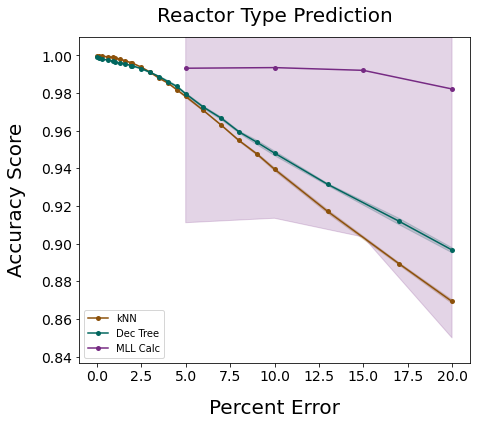

In [68]:
plot_curves('Reactor Type Prediction', 'Acc')

## Burnup

<Figure size 432x288 with 0 Axes>

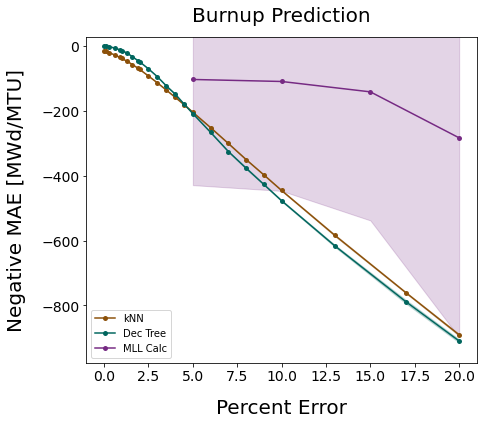

In [76]:
#plot_curves('Burnup Prediction', 'ExpVar')
plot_curves('Burnup Prediction', 'MAE')
#plot_curves('Burnup Prediction', 'RMSE')

## Enrichment

<Figure size 432x288 with 0 Axes>

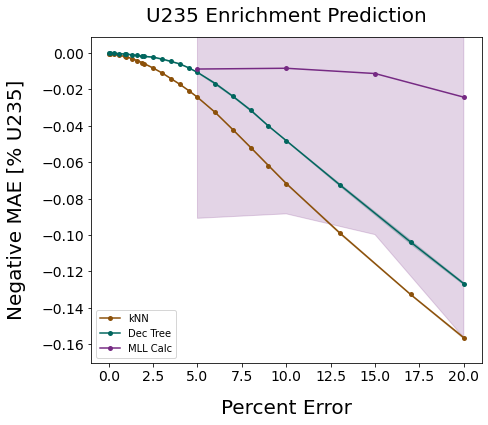

In [80]:
#plot_curves('Enrichment Prediction', 'ExpVar')
plot_curves('U235 Enrichment Prediction', 'MAE')
#plot_curves('Enrichment Prediction', 'RMSE')

## Time Since Irraditation

<Figure size 432x288 with 0 Axes>

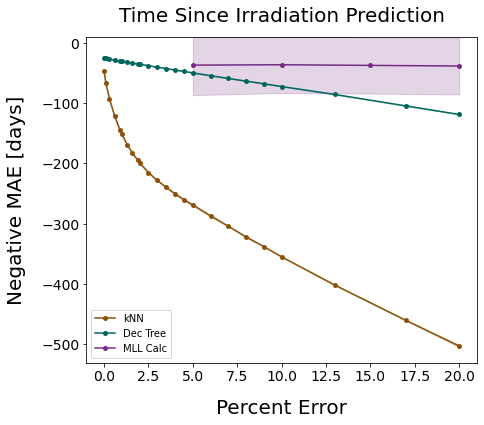

In [82]:
#plot_curves('Time Since Irradiation Prediction', 'ExpVar')
plot_curves('Time Since Irradiation Prediction', 'MAE')
#plot_curves('Time Since Irradiation Prediction', 'RMSE')